<a href="https://colab.research.google.com/github/adrian-valente/XAI_course_labs/blob/main/lab3_saliency_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to seek interpretation of convolutional neural networks performing image recognition, notably via saliency maps and feature visualizations. This will be the occasion to learn specific pytorch features, including hooks.

Let's finally plunge right into the insides of a deep network!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

# Set-up

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
!wget https://adrian-valente.github.io/assets/feature_images.zip
!unzip feature_images.zip
!mv feature_images/* .

--2023-11-28 20:39:56--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-11-28 20:39:56 (85.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

--2023-11-28 20:39:56--  https://adrian-valente.github.io/assets/feature_images.zip
Resolving adrian-valente.github.io (adrian-valente.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to adrian-valente.github.io (adrian-valente.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 636322 (621K) [application/zip]
Saving to:

In [ ]:
# Load the imagenet class labels
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]
inverse_imagenet_classes = {k: i for i, k in enumerate(imagenet_classes)}

In [ ]:
# Load pretrained model and its associated preprocessing
model = models.vgg16(pretrained=True)
preprocess = models.VGG16_Weights.IMAGENET1K_V1.transforms()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Put on GPU and eval mode
model = model.to(device='cuda')
_ = model.eval()

In [ ]:
# Test model
image = Image.open('husky.jpg')
inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')
out = model.forward(inp_tensor)
print(inp_tensor.shape)

probs = F.softmax(out[0], dim=0).cpu()
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

torch.Size([1, 3, 224, 224])
Eskimo dog 0.6295351982116699
Siberian husky 0.3456721007823944
timber wolf 0.00815954152494669
malamute 0.00763235567137599
dogsled 0.004964105784893036


In [ ]:
# A useful construct (listing the architecture of the model)
named_modules = {name: module for name, module in model.named_modules()}
named_modules

{'': VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2

# Part 1: saliency maps

A saliency map represents the pixels that have the highest impact on the decision of a certain network, computed as the gradient of the network's top logit with respect to the input image. More specifically, here we will seek to compute that gradient for each pixel & channel variable in the input image, and then keep the maximal absolute value accross channels for each pixel to ultimately obtain vizualisations of the sort:


In [ ]:
# Complete the following function
def saliency_map(image=None):

    # Boilerplate preprocessing
    if image is None:
      image = torch.tensor([0.485, 0.456, 0.406])
      image = torch.tile(image, (224, 224, 1))\
                      .permute((2, 0, 1))\
                      .unsqueeze(0)\
                      .to(device='cuda')
    else:
      if isinstance(image, Image.Image):
          image = preprocess(image).unsqueeze(0).to(device='cuda')

    # Define input image as a differentiable variable
    V = torch.autograd.Variable(image, requires_grad=True)

    # Run model
    out = model.forward(V)

    # Extract predicted class
    val, idx = torch.max(out, dim=1)
    probs = F.softmax(out, dim=1)
    print(f'Predicted top class: {imagenet_classes[idx]}, '
          f'p={probs[0, idx].item():.2f}')

    # Backpropagate to get gradient of input image wrt predicted class logit
    val.backward()

    # Process saliency
    saliency = V.grad.squeeze(0)   # Remove batch axis
    # Take abs and max along channels
    saliency = torch.max(torch.abs(saliency), dim=0)[0]
    saliency = saliency.detach().cpu().numpy()  # convert to numpy
    return saliency

Predicted top class: Eskimo dog, p=0.63


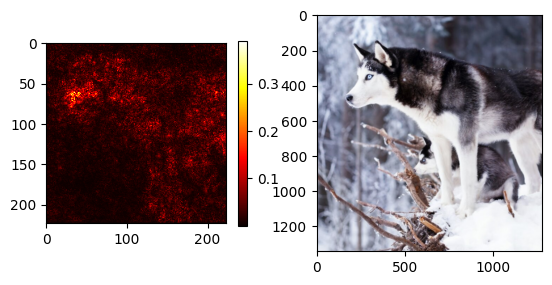

In [ ]:
# Testing it
image = Image.open('husky.jpg')
map = saliency_map(image)
fig, ax = plt.subplots(1, 2)
mappable = ax[0].imshow(map, cmap=plt.cm.hot)
fig.colorbar(mappable, shrink=0.5)
ax[1].imshow(image)

Predicted top class: German shepherd, p=0.43


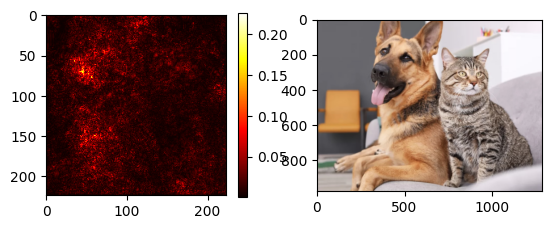

In [ ]:
image = Image.open('dog-cat.jpg')
map = saliency_map(image)
fig, ax = plt.subplots(1, 2)
mappable = ax[0].imshow(map, cmap=plt.cm.hot)
fig.colorbar(mappable, shrink=0.5)
ax[1].imshow(image)

# Part 2: Hooks and activation maps

In [ ]:
# A useful class
class Hook:

    def __init__(self, module, filter):
        self.module = module
        self.filter = filter


    def hook_fn(self, module, input, output):
        self.saved_features = output[:, self.filter].detach()

    def __enter__(self):
        self.hook = self.module.register_forward_hook(self.hook_fn)
        return self

    def __exit__(self, type, value, traceback):
        self.hook.remove()


torch.Size([1, 224, 224])


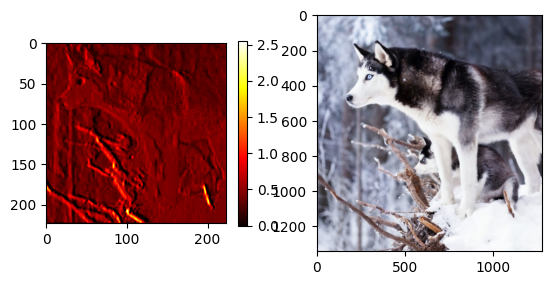

In [ ]:
# Demonstrating the hook
image = Image.open('husky.jpg')
inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')
with Hook(named_modules['features.0'], 0) as hook:
  out = model.forward(inp_tensor)
print(hook.saved_features.shape)
fig, ax = plt.subplots(1, 2)
map = hook.saved_features[0].cpu().numpy()
mappable = ax[0].imshow(map, cmap=plt.cm.hot)
fig.colorbar(mappable, shrink=0.5)
ax[1].imshow(image)

Now you can explore what these activation maps are telling you about the sensitivities of different convolutional filters in the network. The sky is the limit here! Notably see for a given image if you can find which filters are most activated on a given layer. Can you identify what they react to? Form a hypothesis and verify if it holds on other images.

Does the filter relate to the output? (See interventional hooks below).

In [ ]:
def visualize_activation(layer, filter, image):
    inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')
    with Hook(layer, filter) as hook:
      out = model.forward(inp_tensor)
    fig, ax = plt.subplots(1, 2)
    map = hook.saved_features[0].cpu().numpy()
    mappable = ax[0].imshow(map, cmap=plt.cm.hot)
    fig.colorbar(mappable, shrink=0.5)
    ax[1].imshow(image)

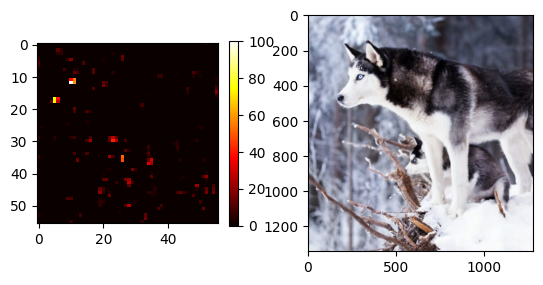

In [ ]:
visualize_activation(named_modules['features.14'], 216, image)

In [ ]:
# Get all max filter activations on a layer:
layer = named_modules['features.14']
inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')
max_activations = []

for filter in range(layer.out_channels):
    with Hook(layer, filter) as hook:
        out = model.forward(inp_tensor)
    map = hook.saved_features[0].cpu().numpy()
    max_activations.append(np.max(map))
np.argsort(max_activations)[::-1][:10]

array([216, 221, 121,  26, 125, 133, 145,  14, 228, 188])

In [ ]:
# Get all max filter activations on a layer:
layer = named_modules['features.28']
inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')
max_activations = []

for filter in range(layer.out_channels):
    with Hook(layer, filter) as hook:
        out = model.forward(inp_tensor)
    map = hook.saved_features[0].cpu().numpy()
    max_activations.append(np.max(map))
np.argsort(max_activations)[::-1][:10]

array([151, 328, 288, 290, 299,  92, 242, 422, 455, 121])

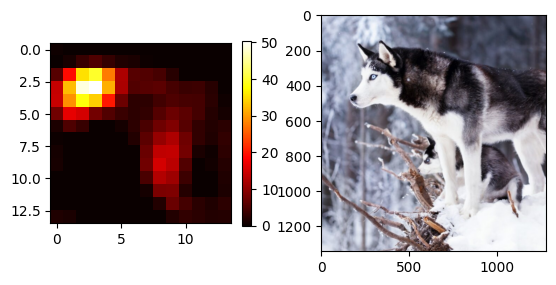

In [ ]:
visualize_activation(named_modules['features.28'], 151, image)

# Part 3: interventional hooks

Let's start meddling with these internal representations. The following class will let you silence a filter of your choice: it can be used as a context manager like this:

```py
with SilenceHook(module, filter):
    out = model.forward(inp_tensor)  # Perturbed run
```

Use it wisely!

In [ ]:
# A useful class
class SilenceHook:

    def __init__(self, module, filter):
        self.module = module
        self.filter = filter

    def hook_fn(self, module, input, output):
        output[:, self.filter] = 0
        return output

    def __enter__(self):
        self.hook = self.module.register_forward_hook(self.hook_fn)
        return self

    def __exit__(self, type, value, traceback):
        self.hook.remove()


In [ ]:
image = Image.open('husky.jpg')
inp_tensor = preprocess(image).unsqueeze(0).to(device='cuda')

out1 = model.forward(inp_tensor).detach()

with SilenceHook(named_modules['features.28'], 151):
    out2 = model.forward(inp_tensor).detach()

probs = F.softmax(out1[0], dim=0).cpu()
top5_prob, top5_catid = torch.topk(probs, 5)
print('Before:')
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

print('\n\nAfter:')
probs = F.softmax(out2[0], dim=0).cpu()
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

Before:
Eskimo dog 0.6295351982116699
Siberian husky 0.3456721007823944
timber wolf 0.00815954152494669
malamute 0.00763235567137599
dogsled 0.004964105784893036


After:
Eskimo dog 0.7127236723899841
Siberian husky 0.2402564138174057
timber wolf 0.008878562599420547
malamute 0.0087980842217803
basenji 0.0069181001745164394


# Part 4: feature visualization

This part is dedicated to letting you implement, practically from scratch, a simple version of the feature visualization algorithm. The algorithm is conceptually simple: we obtain the activations at a certain filter and seek to maximize them (or in this case the mean accross filter positions). Simply this gradient descent with some L2 regularization should already give interesting results, try to implement it. Again experimenting with different images, and in combination with activation maps and interventions, see if you can understand some of the roles some neurons are playing.

In [ ]:
# First we need to modify the hook to make it attached to the computation graph
class AttachedHook:

    def __init__(self, module, filter):
        self.module = module
        self.filter = filter


    def hook_fn(self, module, input, output):
        self.saved_features = output[:, self.filter]  # Only change

    def __enter__(self):
        self.hook = self.module.register_forward_hook(self.hook_fn)
        return self

    def __exit__(self, type, value, traceback):
        self.hook.remove()


In [ ]:
# Normalization statistics for most Imagenet networks
MEAN = torch.Tensor([0.485, 0.456, 0.406])
STD = torch.Tensor([0.229, 0.224, 0.225])

def feature_visualization(
    module,
    filter,
    n_steps=50,
    alpha=10,  # L2 regularization coefficient
    image=None,   # Start from an image if you want (if not from noise)
    verbose=False,
):
    if not image:
        image = torch.rand(224, 224, 3) / 5 + 0.4  # kind of optimized for niceness
        image = (image - MEAN) / STD
        image = image.permute((2, 0, 1)).unsqueeze(0).to(device='cuda')
    else:
        image = preprocess(image).unsqueeze(0).to(device='cuda')

    # Make input differentiable
    v_im = torch.autograd.Variable(image, requires_grad=True)

    # Optimization loop
    optim = torch.optim.Adam([v_im], lr=0.1)
    for i in range(1, n_steps):
        optim.zero_grad()

        # Forward pass
        with AttachedHook(module, filter) as hook:
            _ = model.forward(v_im)

        # Loss function
        loss = -hook.saved_features[0].mean() \
              + alpha * (v_im**2).mean()

        if verbose:
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.item()))
        loss.backward()
        optim.step()

    # Back to image domain
    result = v_im.detach().squeeze(0).permute((1, 2, 0)).cpu()
    result = (result * STD + MEAN).clip(0, 1)
    return result.detach().numpy()


torch.Size([1, 3, 224, 224])
torch.Size([224, 224, 3])


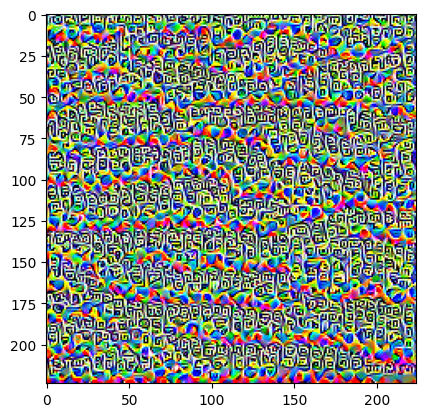

In [ ]:
vis = feature_visualization(named_modules['features.10'], 5, alpha=1)
plt.imshow(vis)

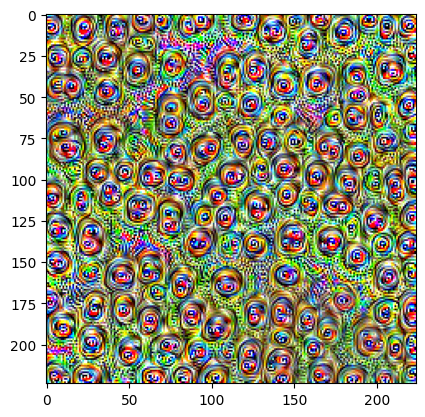

In [ ]:
vis = feature_visualization(named_modules['features.14'], 216, alpha=0.1)
plt.imshow(vis)

torch.Size([1, 3, 224, 224])
torch.Size([224, 224, 3])


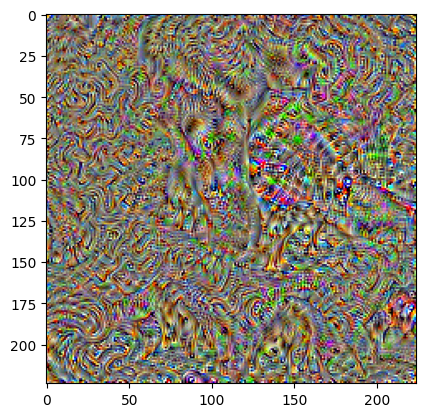

In [ ]:
vis = feature_visualization(named_modules['features.28'], 151, alpha=0.1)
plt.imshow(vis)

In [ ]:
def feature_visualization_upscaling(
    module,
    filter,
    n_steps=20,
    start_size=56,
    upscaling_steps=5,
    upscaling_ratio=1.5,
    alpha=10,             # L2 regularization coefficient
    verbose=False,
):
    size = start_size
    image = torch.rand(3, size, size) / 10 + MEAN[:, None, None]

    for _ in range(upscaling_steps):
        # Image preprocessing
        image = preprocess(image)
        image = image.unsqueeze(0)
        image = image.to(device='cuda')

        # Convert image to differentiable variable
        v_im = torch.autograd.Variable(image, requires_grad=True)

        # Optimization loop
        optim = torch.optim.Adam([v_im], lr=0.1)
        for i in range(1, n_steps):
            optim.zero_grad()
            with AttachedHook(module, filter) as hook:
                _ = model.forward(v_im)
            loss = -hook.saved_features[0].mean() \
                  + alpha * (v_im**2).mean()
            if verbose:
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.item()))
            loss.backward()
            optim.step()

        # Return to image domain
        image = v_im.detach().squeeze(0).permute((1, 2, 0)).cpu()
        image = (image * STD + MEAN).clip(0, 1).permute((2, 0, 1))

        # upscale
        size = int(size * upscaling_ratio)
        image = transforms.Resize((size, size))(image)
    return image.permute((1, 2, 0)).numpy()

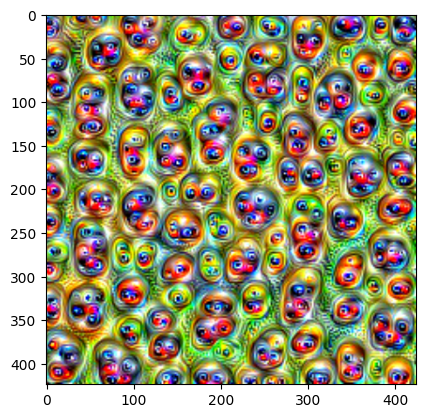

In [ ]:
vis = feature_visualization_upscaling(named_modules['features.14'], 216, alpha=0.1)
plt.imshow(vis)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


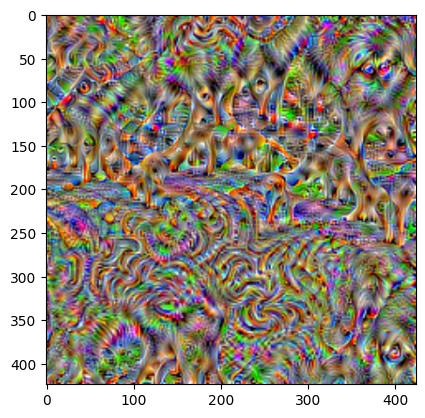

In [ ]:
vis = feature_visualization_upscaling(named_modules['features.28'], 151, alpha=0.1)
plt.imshow(vis)